In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import CyclicLR
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

In [2]:
# Paths
data_dir = "../FBMM/Unsplitted_Ready_Sets/set_01_class_balanced_augs_applied_splitted"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")
pretrained_model_path = "./efficientnet_b2_emotion_model.pth"
model_save_path = "./models/fine_tuned_efficientnet_b2.pth"

In [3]:
# Configuration
batch_size = 16
num_epochs = 50
initial_lr = 1e-4
weight_decay = 1e-4
num_classes = 7
img_height, img_width = 260, 260
seed = 42
accumulation_steps = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Emotion categories
emotion_classes = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [4]:
# Improved Data Augmentation for RGB Dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(260, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

In [5]:
# Compute Class Weights
labels = [label for _, label in train_dataset.samples]
class_counts = np.bincount(labels, minlength=num_classes)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()
sample_weights = [class_weights[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [6]:
# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [7]:
# Load Pretrained EfficientNet-B2 Model and Adapt to RGB
def load_pretrained_model(num_classes, pretrained_path):
    print("Loading pre-trained EfficientNet-B2 model...")

    # Initialize the model architecture
    model = models.efficientnet_b2()

    # Load the pre-trained state dictionary (ignoring size mismatches)
    pretrained_dict = torch.load(pretrained_path, map_location="cpu", weights_only=True)
    model_dict = model.state_dict()

    # Filter out classifier & first conv layer (these need modification)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k not in ["classifier.1.weight", "classifier.1.bias", "features.0.0.weight"]}

    # Load compatible parameters
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict, strict=False)  # Allow mismatches

    # Convert First Layer to RGB (Preserve Grayscale Weights)
    with torch.no_grad():
        old_weights = model.features[0][0].weight.mean(dim=1, keepdim=True)  # Convert grayscale weights
        new_conv_layer = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        new_conv_layer.weight = nn.Parameter(old_weights.repeat(1, 3, 1, 1))  # Expand to 3 channels
        model.features[0][0] = new_conv_layer

    # Modify classifier head to match new num_classes
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier[1].in_features, num_classes)
    )

    return model.to("cuda" if torch.cuda.is_available() else "cpu")

model = load_pretrained_model(num_classes, pretrained_model_path)
print(" Model loaded and modified successfully!")

Loading pre-trained EfficientNet-B2 model...
 Model loaded and modified successfully!


In [8]:
# Custom Focal Loss to Handle Class Imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

criterion = FocalLoss(gamma=2)

In [9]:
# Use AdamW with CyclicLR
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=initial_lr, weight_decay=weight_decay)
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode="triangular")

In [10]:
# Function to Update Class Weights Each Epoch Based on Performance
def update_class_weights(class_correct, class_total, num_classes):
    class_accuracies = {cls: (100 * class_correct[cls] / max(1, class_total[cls])) for cls in emotion_classes}
    
    # Compute inverse accuracy for reweighting
    class_weights = torch.zeros(num_classes, dtype=torch.float32).to(device)
    for i, cls in enumerate(emotion_classes):
        class_weights[i] = 1.0 / (class_accuracies[cls] + 1e-6)
    
    class_weights /= class_weights.sum()
    return class_weights

In [ ]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_val_loss = np.inf

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        class_correct = {cls: 0 for cls in emotion_classes}
        class_total = {cls: 0 for cls in emotion_classes}

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) / accumulation_steps
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for i in range(labels.size(0)):
                class_correct[emotion_classes[labels[i].item()]] += (preds[i] == labels[i]).item()
                class_total[emotion_classes[labels[i].item()]] += 1

        # Compute overall accuracy and loss
        train_loss = total_loss / total
        train_acc = correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Display Metrics
        print(f"\nEpoch {epoch} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
        
        # Show per-class accuracy
        for cls in emotion_classes:
            acc = 100 * class_correct[cls] / max(1, class_total[cls])
            print(f"{cls} Accuracy: {acc:.2f}%")

        # Recalculate Class Weights Based on This Epoch’s Performance
        if epoch > 1:
            class_weights = update_class_weights(class_correct, class_total, num_classes)
            criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1).to(device)
            print(f" Updated Class Weights for Next Epoch: {class_weights.cpu().numpy()}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print("✅ Best Model Saved!")

# Train Model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/50: 100%|██████████| 7751/7751 [59:32<00:00,  2.17it/s]   



Epoch 1 Summary:
Train Loss: 0.0422 | Train Accuracy: 0.7744
Validation Loss: 0.0775 | Validation Accuracy: 0.8499
Anger Accuracy: 72.03%
Disgust Accuracy: 78.19%
Fear Accuracy: 65.34%
Happy Accuracy: 96.02%
Neutral Accuracy: 84.49%
Sad Accuracy: 68.20%
Surprise Accuracy: 77.95%
✅ Best Model Saved!


Epoch 2/50: 100%|██████████| 7751/7751 [1:04:24<00:00,  2.01it/s]



Epoch 2 Summary:
Train Loss: 0.0243 | Train Accuracy: 0.8201
Validation Loss: 0.0673 | Validation Accuracy: 0.8619
Anger Accuracy: 76.90%
Disgust Accuracy: 82.30%
Fear Accuracy: 71.82%
Happy Accuracy: 97.40%
Neutral Accuracy: 88.68%
Sad Accuracy: 74.41%
Surprise Accuracy: 82.51%
✅ Updated Class Weights for Next Epoch: [0.15089934 0.14098278 0.16156217 0.11912782 0.13084248 0.15594707
 0.14063835]
✅ Best Model Saved!


Epoch 3/50: 100%|██████████| 7751/7751 [1:03:32<00:00,  2.03it/s]



Epoch 3 Summary:
Train Loss: 0.1947 | Train Accuracy: 0.8562
Validation Loss: 0.7036 | Validation Accuracy: 0.8857
Anger Accuracy: 82.15%
Disgust Accuracy: 85.53%
Fear Accuracy: 77.80%
Happy Accuracy: 97.79%
Neutral Accuracy: 90.61%
Sad Accuracy: 80.12%
Surprise Accuracy: 85.12%
✅ Updated Class Weights for Next Epoch: [0.14806639 0.14221501 0.15635891 0.12439433 0.13424338 0.15181662
 0.14290541]


Epoch 4/50: 100%|██████████| 7751/7751 [1:03:16<00:00,  2.04it/s]



Epoch 4 Summary:
Train Loss: 0.1776 | Train Accuracy: 0.8857
Validation Loss: 0.6918 | Validation Accuracy: 0.8902
Anger Accuracy: 85.74%
Disgust Accuracy: 88.70%
Fear Accuracy: 82.65%
Happy Accuracy: 98.43%
Neutral Accuracy: 92.46%
Sad Accuracy: 83.25%
Surprise Accuracy: 88.74%
✅ Updated Class Weights for Next Epoch: [0.1470874  0.14218181 0.15259306 0.12813137 0.13640122 0.15148905
 0.1421161 ]


Epoch 5/50: 100%|██████████| 7751/7751 [1:02:10<00:00,  2.08it/s]



Epoch 5 Summary:
Train Loss: 0.1675 | Train Accuracy: 0.9032
Validation Loss: 0.6802 | Validation Accuracy: 0.8956
Anger Accuracy: 87.58%
Disgust Accuracy: 90.69%
Fear Accuracy: 84.74%
Happy Accuracy: 98.71%
Neutral Accuracy: 94.04%
Sad Accuracy: 86.36%
Surprise Accuracy: 90.04%
✅ Updated Class Weights for Next Epoch: [0.14696527 0.14192532 0.15189117 0.13039102 0.13685894 0.14902617
 0.14294209]


Epoch 6/50: 100%|██████████| 7751/7751 [1:07:30<00:00,  1.91it/s]



Epoch 6 Summary:
Train Loss: 0.1609 | Train Accuracy: 0.9165
Validation Loss: 0.6785 | Validation Accuracy: 0.8971
Anger Accuracy: 89.92%
Disgust Accuracy: 92.04%
Fear Accuracy: 86.94%
Happy Accuracy: 98.79%
Neutral Accuracy: 94.40%
Sad Accuracy: 87.90%
Surprise Accuracy: 91.53%
✅ Updated Class Weights for Next Epoch: [0.14535579 0.14202127 0.15034334 0.13231027 0.13845652 0.14870575
 0.14280702]


Epoch 7/50: 100%|██████████| 7751/7751 [1:00:52<00:00,  2.12it/s]



Epoch 7 Summary:
Train Loss: 0.1556 | Train Accuracy: 0.9258
Validation Loss: 0.6857 | Validation Accuracy: 0.8864
Anger Accuracy: 91.08%
Disgust Accuracy: 92.84%
Fear Accuracy: 88.57%
Happy Accuracy: 98.76%
Neutral Accuracy: 94.98%
Sad Accuracy: 89.38%
Surprise Accuracy: 92.45%
✅ Updated Class Weights for Next Epoch: [0.14503819 0.14228195 0.14914988 0.13376267 0.13908066 0.14780077
 0.14288591]


Epoch 8/50: 100%|██████████| 7751/7751 [1:10:29<00:00,  1.83it/s]  



Epoch 8 Summary:
Train Loss: 0.1507 | Train Accuracy: 0.9342
Validation Loss: 0.6671 | Validation Accuracy: 0.9004
Anger Accuracy: 91.81%
Disgust Accuracy: 93.77%
Fear Accuracy: 89.76%
Happy Accuracy: 99.05%
Neutral Accuracy: 95.67%
Sad Accuracy: 90.49%
Surprise Accuracy: 93.50%
✅ Updated Class Weights for Next Epoch: [0.14524516 0.14220436 0.14855492 0.13463314 0.1393788  0.14735852
 0.14262515]


Epoch 9/50: 100%|██████████| 7751/7751 [1:00:32<00:00,  2.13it/s]



Epoch 9 Summary:
Train Loss: 0.1472 | Train Accuracy: 0.9409
Validation Loss: 0.6449 | Validation Accuracy: 0.9113
Anger Accuracy: 92.66%
Disgust Accuracy: 94.48%
Fear Accuracy: 91.23%
Happy Accuracy: 99.11%
Neutral Accuracy: 95.82%
Sad Accuracy: 91.23%
Surprise Accuracy: 94.06%
✅ Updated Class Weights for Next Epoch: [0.14495263 0.14215308 0.14721985 0.1355065  0.1401672  0.14721389
 0.14278688]


Epoch 10/50: 100%|██████████| 7751/7751 [59:45<00:00,  2.16it/s]  



Epoch 10 Summary:
Train Loss: 0.1451 | Train Accuracy: 0.9439
Validation Loss: 0.6022 | Validation Accuracy: 0.9319
Anger Accuracy: 92.98%
Disgust Accuracy: 94.56%
Fear Accuracy: 91.49%
Happy Accuracy: 99.23%
Neutral Accuracy: 96.34%
Sad Accuracy: 91.74%
Surprise Accuracy: 94.42%
✅ Updated Class Weights for Next Epoch: [0.14492995 0.14250919 0.14728326 0.13579829 0.13987255 0.14688796
 0.14271878]


Epoch 11/50: 100%|██████████| 7751/7751 [1:05:21<00:00,  1.98it/s]



Epoch 11 Summary:
Train Loss: 0.1424 | Train Accuracy: 0.9490
Validation Loss: 0.5664 | Validation Accuracy: 0.9470
Anger Accuracy: 93.69%
Disgust Accuracy: 95.09%
Fear Accuracy: 92.26%
Happy Accuracy: 99.16%
Neutral Accuracy: 96.69%
Sad Accuracy: 92.80%
Surprise Accuracy: 94.65%
✅ Updated Class Weights for Next Epoch: [0.14463739 0.14250214 0.1468756  0.13665459 0.1401421  0.14602645
 0.1431618 ]


Epoch 12/50: 100%|██████████| 7751/7751 [1:15:19<00:00,  1.71it/s]  



Epoch 12 Summary:
Train Loss: 0.1405 | Train Accuracy: 0.9522
Validation Loss: 0.5548 | Validation Accuracy: 0.9522
Anger Accuracy: 93.95%
Disgust Accuracy: 95.41%
Fear Accuracy: 92.85%
Happy Accuracy: 99.23%
Neutral Accuracy: 96.73%
Sad Accuracy: 93.16%
Surprise Accuracy: 95.25%
✅ Updated Class Weights for Next Epoch: [0.14473316 0.14251505 0.14644627 0.13702734 0.14057101 0.14595693
 0.1427502 ]


Epoch 13/50:  44%|████▍     | 3411/7751 [36:56<52:53,  1.37it/s]   


🔍 Evaluating the Model on Test Data...


C:\Users\Tuf\AppData\Local\Temp\ipykernel_42516\1833687695.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi


 Test Results:
Anger Accuracy: 82.67%
Disgust Accuracy: 85.56%
Fear Accuracy: 79.69%
Happy Accuracy: 98.51%
Neutral Accuracy: 93.55%
Sad Accuracy: 76.31%
Surprise Accuracy: 87.55%

 Final Test Accuracy: 0.8626

 Classification Report:
               precision    recall  f1-score   support

       Anger     0.8095    0.8267    0.8180      2216
     Disgust     0.8758    0.8556    0.8656      2216
        Fear     0.7991    0.7969    0.7980      2216
       Happy     0.9878    0.9851    0.9864      2216
     Neutral     0.9108    0.9355    0.9230      2216
         Sad     0.8026    0.7631    0.7823      2216
    Surprise     0.8505    0.8755    0.8628      2216

    accuracy                         0.8626     15512
   macro avg     0.8623    0.8626    0.8623     15512
weighted avg     0.8623    0.8626    0.8623     15512



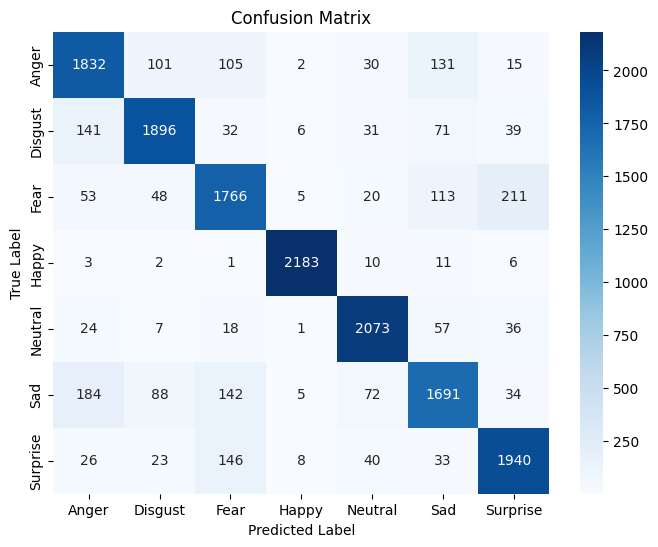

In [11]:
# Function to Evaluate Model on Test Data
def evaluate_model(model, test_loader, model_path):
    print("\n🔍 Evaluating the Model on Test Data...")

    # Load the best saved model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    correct, total = 0, 0
    class_correct = {cls: 0 for cls in emotion_classes}
    class_total = {cls: 0 for cls in emotion_classes}

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(labels.size(0)):
                class_correct[emotion_classes[labels[i].item()]] += (preds[i] == labels[i]).item()
                class_total[emotion_classes[labels[i].item()]] += 1

    # Compute per-class accuracy
    print("\n Test Results:")
    for cls in emotion_classes:
        acc = 100 * class_correct[cls] / max(1, class_total[cls])
        print(f"{cls} Accuracy: {acc:.2f}%")

    # Compute overall test accuracy
    overall_acc = correct / total
    print(f"\n Final Test Accuracy: {overall_acc:.4f}")

    # Generate Classification Report
    report = classification_report(all_labels, all_preds, target_names=emotion_classes, digits=4)
    print("\n Classification Report:\n", report)

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_classes, yticklabels=emotion_classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run Model Evaluation After Training
evaluate_model(model, test_loader, model_save_path)